# Assignment 12

### 1.复习上课内容

### 2.回答以下理论问题

#### 1. 请写一下TF-IDF的计算公式

>TF(Term frequency):在一个文档中，一个词出现的次数: $tf_{t,d}=count(t,d)$,也可以对结果取对数, $tf_{t,d}=log_{10}(count(t,d)+1)$
其中，t=某个词在该文档中出现对频次，d=文档的总词数
>
>IDF(Inverse document frenquency):总文档数除以包含某个词的文档数，再取对数: $idf_t=log_{10}(\frac{N}{df_t})$
其中，N=总文档数，$df_t$=包含t的文档数
>
>TF-IDF = $TF * IDF$

#### 2. LDA算法的基本假设是什么？

>LDA的2个基本假设：
>
>1. Per-document topic distributions: The topics of each document obey a probability distribution(每个文本主题服从某个概率分布)
>2. Per-topic word distributions: The words of each topic obey a probability distribution (每个主题下的词服从一个概率分布)

#### 3. 在TextRank算法中构建图的权重是如何得到的？

>一般是通过计算2个词的词向量之间的余弦相似度来得到的: $W_{ij}=similarity\;cosine(w_i, w_j)$

#### 4. 什么是命名实体识别？ 有什么应用场景？

>命名实体识别指识别文本中具有特定意义的实体，如人名、机构名、地名等专有名词和有意义的时间等；
>
>命名实体识别是关系抽取、事件抽取、知识图谱、信息检索、语义网络、问答系统、句法分析、机器翻译等任务的基础。

#### 5.NLP主要有哪几类任务 ？

>NLP任务:
>
>* 分类任务(Classification tasks)
>  *  情感分析
>  *  文本分类
>  *  实体识别
>* 生成任务(Generation tasks)
>  *  机器翻译
>  *  对话系统(QA)
>  *  文本生成

### 3.实践题

## 3.1 手动实现TextRank算法 (在新闻数据中随机提取100条新闻训练词向量和做做法测试）

 提示：
 1. 确定窗口，建立图链接。   
 2. 通过词向量相似度确定图上边的权重
 3. 根据公式实现算法迭代(d=0.85)

In [16]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import re, os, sys, logging
import jieba
import random
from optparse import OptionParser

In [37]:
# 读取新闻语料
news = pd.read_csv('sqlResult_1558435.csv', encoding='gb18030')['content'].fillna('')

In [27]:
# 获取中文停顿词函数
def get_stopwords():
    stopwords = [line.strip() for line in open('chinese_stopwords.txt',encoding='UTF-8').readlines()]
    return stopwords

In [28]:
stopwords = get_stopwords()

In [50]:
# 中文分词函数，用正则去除多余的符号
def cut_text(text):
    text = str(text)
    text = re.sub('\\\\n|[\n\u3000\r]', '', text)
    relu = '！？｡。，＂＃＄％＆＇（）＊＋－／：；＜＝＞＠［＼］＾＿｀\
    ｛｜｝～｟｠｢｣､、〃《》「」『』【】〔〕〖〗〘〙〚〛〜〝〞〟〰〾〿–\
    —‘\'‛“”„‟…‧﹏' + '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~·ʔ•'
    text = re.sub('[{}]'.format(relu), '', text)
    #text = re.sub('\\\\n|[\n\u3000\r]', '', text)
    seg_list = jieba.cut(text)            
    sentence_segment=[] 
    for word in seg_list:
        if word not in stopwords:
            sentence_segment.append(word.strip())
    #sentence_segment.append(word.strip())        
    # 把已去掉停用词的sentence_segment，用' '.join()拼接起来
    seg_res = ' '.join(sentence_segment)
    return seg_res

In [53]:
new_content = news[:1000].apply(cut_text)

In [54]:
new_content[6]

'夏普 智能手机 市场 排得 号 没落 并于 2013 年 退出 中国 市场 月份 官方 回归 中国 预示 很快 夏普 新机 中国 登场 第一款 夏普 手机 登陆 中国 手机 近日 一款 型号 FS8016 夏普 神秘 新机 悄然 GeekBench 跑 分库 相关 信息 这款 机子 旗舰 定位 搭载 高通 骁龙 660 处理器 配备 4GB 内存 骁龙 660 高通 最受 瞩目 芯片 采用 14 纳米 工艺 八个 Kryo260 核心 设计 集成 Adreno512GPU X12LTE 调制解调器 市面上 一款 机子 采用 骁龙 660 处理器 上市 销售 OPPOR11 骁龙 660 旗舰 芯片 核新能 去年 骁龙 820 强 单核 改进 放在 手机 高端 机 OPPO 高通 签署 排他性 协议 独占 两三个 月 时间 夏普 测试 新机 独占 时期 一过 夏普 发布 骁龙 660 新品 曝光 渲染 图 夏普 新机 核心 竞争 优势 屏 2013 年 推出 全球 首款 屏 手机 EDGEST302SH 夏普 手机 推出 多达 28 款 屏 手机 月份 媒体 沟通 会上 惠普 罗忠生 我敢 打赌 12 月 在座 手机 换掉 屏 时代 到来 怀揣 手机 传统 手机'

### TextRank算法

#### TextRank关键字提取

In [60]:
from collections import defaultdict

In [61]:
class TextRank():
    
    def __init__(self, content, wv):
        self.content = content
        self.wv = wv
        self.wordmap = defaultdict(set)
        
    # 添加关系
    def add_to_wordmap(self, words):
        for i in range(len(words) - 1):
            for j in range(len(words[i:]) - 1):
                # 因为要用词向量计算权重，因此如果某个词没有词向量，则不建立联系
                if words[i] != words[j] and words[i] in self.wv and words[j] in self.wv:
                    self.wordmap[words[i]].add(words[j])
                    self.wordmap[words[j]].add(words[i])
    
    # 根据窗口大小构建每个节点的相邻节点,返回边的集合 
    def createNodes(self, window=3):
        word_list = self.content.split()
        if len(word_list) < window:
            self.add_to_wordmap(word_list)
        else:
            for i in range(len(word_list) - window + 1):
                self.add_to_wordmap(word_list[i:i+window])
    
    def cosine(self, word1, word2):
        wv1 = self.wv[word1]
        wv2 = self.wv[word2]
        return np.dot(wv1.T, wv2)[0][0] / (np.linalg.norm(wv1) * np.linalg.norm(wv2))
    
    # 根据边的相连关系，构建矩阵 
    def createMatrix(self):
        self.words = list(self.wordmap.keys())
        self.matrix = np.zeros([len(self.words), len(self.words)])
        # 记录词的index
        self.word_index = {}
        
        for i, word in enumerate(self.words):
            self.word_index[word] = i
        
        for word_i in self.words:
            for word_j in self.wordmap[word_i]:
                weight = self.cosine(word_i, word_j) / sum([self.cosine(word_j, word_k) for word_k in self.wordmap[word_j]])
                self.matrix[self.word_index[word_i], self.word_index[word_j]] = weight
    
    #根据textrank公式计算权重 
    def calculate(self, num_iters = 1000, d=0.85):
        self.WS = np.ones([len(self.words), 1]) / len(self.words)
        for i in range(num_iters):
            self.WS = (1 - d) + d * np.dot(self.matrix, self.WS)
    
    # 输出词和相应的权重
    def get_result(self):
        ws_dict = {}
        for word in self.words:
            ws_dict[word] = self.WS[self.word_index[word]][0]
        return ws_dict

> ### 尝试使用TfidfVectorizer获取向量

In [55]:
# 默认pattern是只匹配长度大于等于2的词
new_content_vec = TfidfVectorizer(max_features=10000, token_pattern='(?u)\\b\\w+\\b')

In [56]:
X = new_content_vec.fit_transform(new_content)

In [57]:
X.shape

(1000, 10000)

In [58]:
# 获取TfidfVectorizer向量里面的词和向量对应的dict
def get_wordvec_dict(X):
    wordvec_dict = {}
    for word in new_content_vec.vocabulary_.keys():
        wordvec_dict[word] = X[:, new_content_vec.vocabulary_[word]].toarray()
    return wordvec_dict

In [59]:
# eg：{某个词：向量}
wordvec_dict = get_wordvec_dict(X)

In [62]:
def get_keyword(content, wordvec_dict, topn=10):
    tr = TextRank(content, wordvec_dict)
    tr.createNodes(window=3)
    tr.createMatrix()
    tr.calculate(num_iters=1000, d=0.85)
    ws = tr.get_result()
    for item in sorted(ws.items(), key=lambda x: x[1], reverse=True)[:topn]:
        print('word:{0:{2}<10}, weight:{1:.4f}'.format(item[0], item[1], chr(12288)))

In [63]:
get_keyword(random.choice(new_content),wordvec_dict)

word:发展　　　　　　　　, weight:5.2888
word:经济　　　　　　　　, weight:3.5340
word:新　　　　　　　　　, weight:3.2161
word:年　　　　　　　　　, weight:3.0234
word:顺义　　　　　　　　, weight:2.7919
word:企业　　　　　　　　, weight:2.4069
word:厂房　　　　　　　　, weight:2.2665
word:产业　　　　　　　　, weight:2.0502
word:北京　　　　　　　　, weight:1.8391
word:中　　　　　　　　　, weight:1.8035


>### 尝试使用gensim里的FastText获取关键字

In [64]:
# 把已分词的文件导出为txt文件，按正常来说，训练词向量，不需要去停留词的
pd.DataFrame(new_content).to_csv('news.txt',header=None,index=None)

In [65]:
import os, sys
import logging
import multiprocessing
from optparse import OptionParser
from gensim.corpora import WikiCorpus
from gensim.models import Word2Vec
from gensim.models import FastText
from gensim.models.word2vec import LineSentence

# FastText训练词向量模型函数
def FastText_train(infile,outmodel,outvector,size,window,min_count,sg):
    '''train the word vectors by FastText'''
    
    # 训练模型
    model = FastText(LineSentence(infile),size=size,window=window,min_count=min_count,sg=sg,workers=multiprocessing.cpu_count())  

    # 保存模型
    model.save(outmodel)
    model.wv.save_word2vec_format(outvector,binary=False)


# FastText程序主函数
def FastText_train_main():
    infile = 'news.txt'
    outmodel = 'news.FastText_min_count1.model'
    outvec = 'news.FastText_min_count1.vectors'
    vec_size = 200
    window = 5
    min_count = 1
    sg = 1

    try:       
        FastText_train(infile, outmodel, outvec, vec_size, window, min_count,sg)
        logger.info('FastText model training finished')
    except Exception as err:
        logger.info(err)    
    
       
if __name__ == '__main__':
    # 返回当前运行的py文件名称
    program = os.path.basename(sys.argv[0])
    # logging.basicConfig函数中，可以指定日志的输出格式format，这个参数可以输出很多有用的信息
    # %(asctime)s: 打印日志的时间     %(levelname)s: 打印日志级别名称      %(message)s: 打印日志信息
    logging.basicConfig(level = logging.INFO, format = '%(asctime)s - %(levelname)s - %(message)s')
    # logging.getLogger(name)方法进行初始化，name可以不填。通常logger的名字我们对应模块名
    logger = logging.getLogger(program)  # logging.getLogger(logger_name)
    # logger.info打印程序运行是的正常的信息，用于替代print输出
    logger.info('running ' + program)    
    # 运行程序主函数
    FastText_train_main()

2020-04-09 12:52:46,611 - INFO - running ipykernel_launcher.py
2020-04-09 12:52:46,612 - INFO - resetting layer weights
2020-04-09 12:52:54,520 - INFO - collecting all words and their counts
2020-04-09 12:52:54,522 - INFO - PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-04-09 12:52:54,587 - INFO - collected 46083 word types from a corpus of 282096 raw words and 1000 sentences
2020-04-09 12:52:54,588 - INFO - Loading a fresh vocabulary
2020-04-09 12:52:54,669 - INFO - effective_min_count=1 retains 46083 unique words (100% of original 46083, drops 0)
2020-04-09 12:52:54,669 - INFO - effective_min_count=1 leaves 282096 word corpus (100% of original 282096, drops 0)
2020-04-09 12:52:54,764 - INFO - deleting the raw counts dictionary of 46083 items
2020-04-09 12:52:54,765 - INFO - sample=0.001 downsamples 7 most-common words
2020-04-09 12:52:54,766 - INFO - downsampling leaves estimated 279082 word corpus (98.9% of prior 282096)
2020-04-09 12:52:54,985 - INFO - estim

In [66]:
# 加载模型
FASTTEXT_MODEL_DIR = 'news.FastText_min_count1.model'
model = FastText.load(FASTTEXT_MODEL_DIR)

2020-04-09 12:53:40,185 - INFO - loading FastText object from news.FastText_min_count1.model
2020-04-09 12:53:40,875 - INFO - loading wv recursively from news.FastText_min_count1.model.wv.* with mmap=None
2020-04-09 12:53:40,875 - INFO - loading vectors_ngrams from news.FastText_min_count1.model.wv.vectors_ngrams.npy with mmap=None
2020-04-09 12:53:41,426 - INFO - setting ignored attribute vectors_norm to None
2020-04-09 12:53:41,427 - INFO - setting ignored attribute vectors_vocab_norm to None
2020-04-09 12:53:41,427 - INFO - setting ignored attribute vectors_ngrams_norm to None
2020-04-09 12:53:41,427 - INFO - setting ignored attribute buckets_word to None
2020-04-09 12:53:41,428 - INFO - loading vocabulary recursively from news.FastText_min_count1.model.vocabulary.* with mmap=None
2020-04-09 12:53:41,429 - INFO - loading trainables recursively from news.FastText_min_count1.model.trainables.* with mmap=None
2020-04-09 12:53:41,429 - INFO - loading vectors_ngrams_lockf from news.FastT

In [71]:
def get_word2vec_dict(model):
    word2vec_dict = {}
    for word in model.wv.index2word:
        if len(word) >= 2:
            word2vec_dict[word] = model.wv[word].reshape(-1,1)
    return word2vec_dict

In [72]:
word2vec_dict = get_word2vec_dict(model)

> ### 基于FastText和TfidfVectorizer训练的词向量获取关键字的运行时间对比

In [73]:
%%time
# 基于FastText训练的词向量获取关键字
get_keyword(new_content[6],word2vec_dict)

word:手机　　　　　　　　, weight:3.9151
word:夏普　　　　　　　　, weight:3.9136
word:骁龙　　　　　　　　, weight:2.7582
word:新机　　　　　　　　, weight:2.5062
word:中国　　　　　　　　, weight:2.3136
word:高通　　　　　　　　, weight:2.1919
word:660　　　　　　　, weight:1.7684
word:核心　　　　　　　　, weight:1.6195
word:独占　　　　　　　　, weight:1.6180
word:机子　　　　　　　　, weight:1.5316
Wall time: 48.9 ms


In [74]:
%%time
# 基于TfidfVectorizer训练的词向量获取关键字
get_keyword(new_content[6],wordvec_dict)

word:手机　　　　　　　　, weight:3.7568
word:骁龙　　　　　　　　, weight:3.4484
word:新机　　　　　　　　, weight:3.2995
word:660　　　　　　　, weight:3.0032
word:夏普　　　　　　　　, weight:2.4547
word:中国　　　　　　　　, weight:2.3452
word:机子　　　　　　　　, weight:2.1771
word:高通　　　　　　　　, weight:2.0832
word:旗舰　　　　　　　　, weight:2.0483
word:2013　　　　　　, weight:1.9524
Wall time: 16.9 ms


### ------------------------------------------------------   分割线   ------------------------------------------------------

## 选择1 使用词向量和k-means的方法寻找关键词

提示：
1. 使用3.1训练好的词向量
2. 可使用sklearn等机器学习库

In [75]:
# 导入KMeans
from sklearn.cluster import KMeans

In [80]:
class keyword_kmeans():
    
    def __init__(self, train_wv, wv_dict, n_clusters=3, max_iter=500):
        self.centers = KMeans(n_clusters=n_clusters, max_iter=max_iter).fit(train_wv).cluster_centers_
        self.wv_dict = wv_dict
        
    def distance(self, wordvec):
        dist_l = []
        for i, center in enumerate(self.centers):
            dist = np.dot(center, wordvec)[0] / (np.linalg.norm(center) * np.linalg.norm(wordvec))
            dist_l.append((i, dist))
        return max(dist_l, key=lambda x: x[1])
    
    def calculate(self, content, topn=10):
        words = list(set(content.split()))
        self.keywords = sorted([(word, self.distance(self.wv_dict[word])) for word in words if word in self.wv_dict and len(word) >=2], 
                               key=lambda x:x[1][1], reverse=True)[:topn]
    
    def get_result(self, print_out=True):
        if print_out:
            for word, (center, dist) in self.keywords:
                print('word:{0:{3}<4}, center:{1:<2}, distance:{2:.4f}'.format(word, center, dist, chr(12288)))
        else:
            return self.keywords

In [84]:
def get_kmeans_keywords(content, train_wv, wv_dict, n_clusters):
    keywords = keyword_kmeans(train_wv, wv_dict, n_clusters)
    keywords.calculate(random.choice(new_content))
    return keywords.get_result()

In [139]:
%%time
get_kmeans_keywords(new_content[6], X.T, wordvec_dict, n_clusters=3)

word:超过　　, center:1 , distance:0.4027
word:中国　　, center:0 , distance:0.3846
word:公司　　, center:1 , distance:0.3617
word:10　　, center:0 , distance:0.3613
word:23　　, center:2 , distance:0.3464
word:未来　　, center:2 , distance:0.3316
word:北京　　, center:2 , distance:0.3195
word:显示　　, center:2 , distance:0.2947
word:合作　　, center:2 , distance:0.2846
word:国内　　, center:0 , distance:0.2719
Wall time: 10.8 s


### ------------------------------------------------------   分割线   ------------------------------------------------------

## 选做 2.  提取新闻人物里的对话。(使用以上提取小数据即可）

提示：    
1.寻找预料里具有表示说的意思。    
2.使用语法分析提取句子结构。    
3.检测谓语是否有表示说的意思。

In [3]:
import re
import jieba
from gensim.models import Word2Vec
from collections import defaultdict
import os
from gensim.models import KeyedVectors
from pyltp import SentenceSplitter, NamedEntityRecognizer, Postagger, Parser, Segmentor

In [ ]:
speak_words = ['表示', '说', '回复', '指出', '认为', '坦言', '告诉', '强调', '称', '直言', '普遍认为', '介绍', '透露', '重申', '呼吁', '说道', '感叹',
               '地说', '写道',
               '中称', '证实', '还称', '猜测', '暗示', '感慨', '热议', '敦促', '指责', '声称', '主张', '反对', '批评', '表态', '中说', '承认', '却说',
               '感触',
               '提到', '所说', '引述', '质疑', '抨击', '回应', '分析说', '发现', '表示', '表态', '推测', '推断', '判决', '判定', '要求']

In [4]:
# 从词向量模型里获取与“说”相关的词，推荐使用腾讯的词向量，但占用内存比较大
def get_related_words(initial_words, model):
    """
    @initial_words are initial words we already know
    @model is the word2vec model
    """
    unseen = initial_words
    seen = defaultdict(int)
    max_size = 500
    while unseen and len(seen) < max_size:
        if len(seen) % 100 == 0:
            print('seen length : {}'.format(len(seen)))
        node = unseen.pop(0)
        new_expanding = [w for w, s in model.wv.most_similar(node, topn=5) if s>0]
        unseen += new_expanding
        seen[node] += 1
    return seen

# 获取相关字的函数
def get_words_said(model_path):
    # 加载词向量模型，可以选用项目1训练好的文件,也可以选用其他预训练的模型
    model = KeyedVectors.load_word2vec_format(model_path, binary=False)
    model.init_sims(replace=True)
    related_words = get_related_words(['说', '表示', '认为'], model)
    related_words = sorted(related_words.items(), key=lambda x: x[1], reverse=True)
    said = [i[0] for i in related_words if i[1] >= 1]
    return said


def save_said(path):
    said = get_words_said(path)
    string = '|'.join(said)
    try:
        with open("similar_said.txt", 'w') as f:
            f.write(string)
        return True
    except:
        return False


def load_said(filename):
    if os.path.exists(filename):
        with open(filename, 'r') as f:
            string = f.readlines()
            string = string[0].split('|')
            return string

In [5]:
# 腾讯词向量文件路径
path = 'H:/1-开课吧/Tencent_AILab_ChineseEmbedding.txt'
# 获得与“说”相关的字，并保存
result = save_said(path)
result

seen length : 0


D:\Users\Jerry\anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


seen length : 100
seen length : 100
seen length : 100
seen length : 100
seen length : 100
seen length : 100
seen length : 200
seen length : 300
seen length : 400
seen length : 400


True

In [9]:
# 分词
def cut(string):
    return ' '.join(jieba.cut(string))

# 处理文本
def token(string):
    string = re.findall('[\d|\w|\u3002 |\uff1f |\uff01 |\uff0c |\u3001 |\uff1b |\uff1a |\u201c |\u201d |\u2018 |\u2019 |\uff08 |\uff09 |\u300a |\u300b |\u3008 |\u3009 |\u3010 |\u3011 |\u300e |\u300f |\u300c |\u300d |\ufe43 |\ufe44 |\u3014 |\u3015 |\u2026 |\u2014 |\uff5e |\ufe4f |\uffe5]+', string)
    return ' '.join(string)

# 处理文本和分词
def deal(string):
    string = token(string)
    return cut(string)        

In [33]:
# 使用SentenceSplitter分句
def split_sentences(string):
    sents = SentenceSplitter.split(string)
    sentences = [s for s in sents if len(s) != 0]
    return sentences

# 处理句子文本和分词
def split_words(sentences):
    sents = [deal(s) for s in sentences]
    return sents

#  得到词性标注
def get_word_pos(ltp_model_path, sents):
    model_path = ltp_model_path
    pos_model_path = os.path.join(model_path, 'pos.model')
    from pyltp import Postagger
    postagger = Postagger()
    postagger.load(pos_model_path)
    postags = [postagger.postag(words.split()) for words in sents]
    postags = [list(w) for w in postags]

    postagger.release()
    return postags

# 句法分析
def dependency_parsing(ltp_model_path, sents, postags, said):
    # ltp模型目录的路径
    LTP_DATA_DIR = ltp_model_path 
    # 依存句法分析模型路径，模型名称为`parser.model`
    par_model_path = os.path.join(LTP_DATA_DIR, 'parser.model')  
    # 初始化实例
    parser = Parser()  
    # 加载依存句法分析模型
    parser.load(par_model_path)      
        
    # 命名实体识别模型路径，模型名称为`ner.model`
    ner_model_path = os.path.join(LTP_DATA_DIR, 'ner.model') 
    # 初始化实例
    recognizer = NamedEntityRecognizer() 
    # 加载命名实体识别模型
    recognizer.load(ner_model_path)  

    # 定义最后获取的内容空列表
    contents = []
    for index in range(len(sents)):
        wo = sents[index].split()
        po = postags[index]
        # 命名实体识别
        netags = recognizer.recognize(wo, po)  
        netags = list(netags)
        if ('S-Ns' not in netags) and ('S-Ni' not in netags) and ('S-Nh' not in netags):
            continue
        # 句法分析
        arcs = parser.parse(wo, po)  
        arcs = [(arc.head, arc.relation) for arc in arcs]

        arcs = [(i, arc) for i, arc in enumerate(arcs) if arc[1] == 'SBV']
        for arc in arcs:
            verb = arc[1][0]
            subject = arc[0]
            if wo[verb - 1] not in said:
                continue

            contents.append((wo[subject], wo[verb - 1], ''.join(wo[verb:])))
    return contents


def get_speech_extraction(string):
    # 加载保存与“说”相关的txt文件
    said = load_said("similar_said.txt")
    speak = ['表示', '说', '回复', '指出', '认为', '坦言', '告诉', '强调', 
                   '称', '直言', '普遍认为', '介绍', '透露', '重申', '呼吁', '说道',
                   '感叹', '地说', '写道', '中称', '证实', '还称', '猜测', '暗示', 
                   '感慨', '热议', '敦促', '指责', '声称', '主张', '反对', '批评',
                   '表态', '中说', '承认', '却说', '感触', '提到', '所说', '引述',
                   '质疑', '抨击', '回应', '分析说', '发现', '表示', '表态', '推测', 
                   '推断', '判决', '判定', '要求', '宣布']
    speak_words = list(set(said + speak))
    # ltp 模型文件路径
    ltp_model_path = '../ltp_model/'
    # 分句
    sentences = split_sentences(string)
    # 处理句子文本和分词
    sents = split_words(sentences)
    # 得到词性标注
    postags = get_word_pos(ltp_model_path, sents)
    # 句法分析后获得的内容
    contents = dependency_parsing(ltp_model_path, sents, postags, speak_words)
    contents_dict = {}
    for indx, ones in enumerate(contents):
        contents_dict[str(indx)] = [ones[0], ones[1], ones[2][1:]]
    
    speech_contents = pd.DataFrame(contents_dict,index=['Person','Speak','Contents']).T
    
    return speech_contents



In [45]:
news_contents = """
习近平指出，当前，墨西哥等拉美和加勒比国家疫情不断发展，我代表中国政府和中国人民，向墨西哥政府和人民表示诚挚慰问和坚定支持。相信在总统先生领导下，墨西哥能够尽快战胜疫情。中方愿继续向墨方提供力所能及的支持，包括协助墨方在中国采购急需防疫物资。双方还可以继续以专家视频会议等方式交流防控和诊疗经验。 
习近平强调，中方始终秉持人类命运共同体理念，积极开展抗疫国际合作，坚定支持世卫组织工作。在二十国集团领导人应对新冠肺炎特别峰会上，我就抗疫国际合作和稳定世界经济提出了4点倡议。中方愿同包括墨西哥在内的各成员国加强沟通协调，落实峰会共识。相信通过这次抗疫合作，中墨两国人民友谊将不断深化，双边关系的战略性将不断提高。中方愿同墨方加强在联合国等多边框架内沟通协调，共同推动构建人类命运共同体。
洛佩斯表示，墨方当前正处于抗击新冠肺炎疫情的困难时刻，中方为墨方抗疫提供了宝贵支持和帮助，这对墨方非常重要。墨西哥同中国一直保持着兄弟般的友好关系，墨方将继续致力于积极发展对华关系，同中方加强抗疫和公共卫生等各领域交流合作。
"""


In [46]:
get_speech_extraction(news_contents)

,Person,Speak,Contents
0,习近平,指出,当前，墨西哥等拉美和加勒比国家疫情不断发展，我代表中国政府和中国人民，向墨西哥政府和人民表示...
1,习近平,强调,中方始终秉持人类命运共同体理念，积极开展抗疫国际合作，坚定支持世卫组织工作。
2,洛佩斯,表示,墨方当前正处于抗击新冠肺炎疫情的困难时刻，中方为墨方抗疫提供了宝贵支持和帮助，这对墨方非常重要。


### ------------------------------------------------------   分割线   ------------------------------------------------------

## 选择3. ： 电影评论分类。

在这个作业中你要完成一个电影评论分类任务。

1.数据获取。（采用爬虫技术爬取相关网页上的电影评论数据，例如猫眼电影评论，豆瓣电影评论）

2.把所获得数据分解为训练集，验证集和测试集。

3.选用相应算法构建模型，并测试。

> #### 数据集地址：https://pan.baidu.com/s/1c0yn3TlkzHYTdEBz3T5arA#list/path=%2F

In [16]:
import pandas as pd

In [14]:
ratings = pd.read_csv('H:/3-NLP数据集/1-电影评论/ratings.csv')

print('用户数据：%d' % ratings.userId.unique().shape[0])
print('评分数目：%d' % ratings.shape[0])

用户数据：738701
评分数目：2125056


In [15]:
ratings_with_opinions = ratings[(ratings.rating==1) | (ratings.rating==5)]

print('正向（5星）数目：%d' % (ratings_with_opinions[ratings_with_opinions.rating==5].shape[0]))
print('负向（1星）数目：%d' % (ratings_with_opinions[ratings_with_opinions.rating==1].shape[0]))

ratings_with_opinions.sample(10)

正向（5星）数目：638106
负向（1星）数目：190927


,userId,movieId,rating,timestamp,comment,like
698338,13682,10,5,1485619200,别总在每一部电影要期待惊天动地的爱情。我认为魔幻，色彩，想象，故事都是不错的。那么差评的人...,7
719834,371166,10,5,1485532800,这么好看的电影评分这么低真的科学么？,11
2019907,56671,27,5,1457193600,美帝就是厉害，不得不服。,0
294431,200233,5,5,1436544000,除了有点老套简单的剧情，其他全部很好。国漫电影良心之作。日漫痕迹基本没有了，特效和画风简直...,1
33384,31692,0,5,1462118400,终于想起来了 我从加州回来之后去看的 叶骏,0
1800461,670744,24,1,1474905600,只是一部有点温暖的商业片，分数太高了！不能人云亦云,0
117956,35546,1,5,1468080000,不完美，但却恰到好处。这部电影不会火，因为太有意境和情怀。现在大众的艺术欣赏水平更喜欢搞笑...,3
1721578,176004,24,5,1473868800,僵尸跑起来真带劲,0
301967,5193,5,5,1436889600,其实剧本写得一般，节奏没掌握好，有一些笑点很没必要，但大圣的音乐一响起来我就泪目了。因为他...,0
380384,63701,5,5,1461427200,家里看的，所以没有感受到大家说的十分震撼。但还是随大流给好评。,0


>### 机器学习方法 做短文本分类

In [1]:
import pandas as pd
import numpy as np
import re
import jieba
from sklearn.model_selection import train_test_split                #划分训练/测试集
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from xgboost.sklearn import XGBClassifier
import lightgbm as lgb
import xgboost as xgb    
from bayes_opt import BayesianOptimization
from sklearn.metrics import roc_auc_score,precision_score,recall_score,f1_score,roc_curve,auc
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import os
%matplotlib inline

In [2]:
# 获取中文停顿词函数
def getStopwords():
    stopwords = [line.strip() for line in open('chinese_stopwords.txt',encoding='UTF-8').readlines()]
    return stopwords

# 获取中文停顿词
stopwords = getStopwords()

In [28]:
# 读取影评数据函数
def read_data():
    # 用pd.read_csv方法读取数据
    data = pd.read_csv('H:/3-NLP数据集/1-电影评论/ratings.csv')
    data = data.loc[:, ['comment', 'rating']]
    df = pd.DataFrame()
    data['rating'][(data['rating']<=3)] = 0
    data['rating'][(data['rating']> 3)] = 1
    data1 = data[(data['rating']==0) & (data['comment'].str.len()>10)][:400000]
    data2 = data[(data['rating']==1) & (data['comment'].str.len()>10)][:400000]    
    df = pd.concat([data1,data2])
    X = df['comment']
    y = df['rating']
    return X, y

In [246]:
data = pd.read_csv('H:/3-NLP数据集/1-电影评论/ratings.csv')
data = data.loc[:, ['comment', 'rating']]

In [248]:
df = pd.DataFrame()
data1 = data[(data['rating']==1) & (data['comment'].str.len()>10)][:100000]
data2 = data[(data['rating']==2) & (data['comment'].str.len()>10)][:100000]
data3 = data[(data['rating']==3) & (data['comment'].str.len()>10)][:100000]
data4 = data[(data['rating']==4) & (data['comment'].str.len()>10)][:100000]
data5 = data[(data['rating']==5) & (data['comment'].str.len()>10)][:100000]

In [249]:
df = pd.concat([data1,data2,data3,data4,data5])

In [224]:
df = pd.DataFrame()
data['rating'][(data['rating']<=3)] = 0
data['rating'][(data['rating']> 3)] = 1
data1 = data[(data['rating']==0) & (data['comment'].str.len()>10)][:400000]
data2 = data[(data['rating']==1) & (data['comment'].str.len()>10)][:400000]

D:\Users\Jerry\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
D:\Users\Jerry\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [225]:
df = pd.concat([data1,data2])

In [250]:
list(set(df['rating']))

[1, 2, 3, 4, 5]

In [29]:
# 读取数据
X, y = read_data()

D:\Users\Jerry\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
D:\Users\Jerry\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [270]:
# 中文分词函数，用正则去除多余的符号
def cut_text(text):
    text = str(text)
    text = re.sub('\\\\n|[\n\u3000\r]', ' ', text)
    relu = '！？｡。，＂＃＄％＆＇（）＊＋－／：；＜＝＞＠［＼］＾＿｀\
    ｛｜｝～｟｠｢｣､、〃《》「」『』【】〔〕〖〗〘〙〚〛〜〝〞〟〰〾〿–\
    —‘\'‛“”„‟…‧﹏' + '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~·ʔ•'
    text = re.sub('[{}]'.format(relu), ' ', text)
    seg_list = jieba.cut(text)            
    sentence_segment=[] 
    for word in seg_list:
        if word not in stopwords:
            sentence_segment.append(word.strip())
    #sentence_segment.append(word)        
    # 把已去掉停用词的sentence_segment，用' '.join()拼接起来
    seg_res = ' '.join(sentence_segment)
    return seg_res

In [45]:
# 定义分类评估指标，actual为真实的类别，predict为预测的类别，predict_prod为预测类别的概率
def metrics_result(actual, predict, predict_prod):  
    precision_scores = precision_score(actual, predict,average='weighted')
    recall_scores = recall_score(actual, predict,average='weighted')
    f1_scores = f1_score(actual, predict,average='weighted')
    #fpr, tpr, threshold = roc_curve(actual,predict_prod)
    #auc_scores = auc(fpr, tpr)
    print('精度:{0:.3f}'.format(precision_scores))
    print('召回:{0:0.3f}'.format(recall_scores))  
    print('f1-score:{0:.3f}'.format(f1_scores))
    #print('AUC:{0:.3f}'.format(auc_scores))
    return precision_scores, recall_scores, f1_scores

In [272]:
# 定义roc_curve_plot函数，用于绘制roc_curve图
def roc_curve_plot(y_test,y_pred):
    fpr, tpr, threshold = roc_curve(y_test,y_pred, pos_label=None, sample_weight=None,drop_intermediate=True)
    fig, ax = plt.subplots(figsize=(10,6))
    ax.plot(fpr, tpr)
    ax.plot([-0.005,1.01],[-0.005,1.01], ls='--')
    plt.xlim([-0.005,1.01])
    plt.ylim([-0.005,1.01])
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show() 
    return fpr,tpr

In [273]:
%%time
# 运行分词函数（分词时间约12分钟）
yingping = X.apply(cut_text)

Wall time: 8min 39s


In [274]:
# 保存分词结果
yingping.to_csv('yingping800000.csv')

In [21]:
# 读取分词csv文件
yingping_X = pd.read_csv('yingping800000.csv',index_col=0)

In [22]:
yingping_X.columns=['comment']
yingping_X.head()

,comment
0,奥创 整容 韩国
1,失望 剧本 敷衍了事 主线 剧情 突破 理解 人物 缺乏 动机 正邪 之间 妇联...
2,2015 年度 失望 作品 面面俱到 实则 画蛇添足 主题深刻 实则 老调重弹 ...
4,打到 尾 真的 无聊
5,剧情 第一集 好玩 全靠 密集 笑点 提神 僧多粥少 后果 每部 寡姐 换 队友 谈恋...


In [23]:
# TfidfVectorizer 是 CountVectorizer + TfidfTransformer的组合，输出的各个文本各个词的TF-IDF值
# min_df=5, max_features=10000
tfidf_vec = TfidfVectorizer(min_df=5, max_features=50000) 
tfidf_matrix = tfidf_vec.fit_transform(yingping_X['comment'].astype('U'))

In [24]:
tfidf_matrix.shape

(800000, 50000)

In [25]:
tfidf_matrix

<800000x50000 sparse matrix of type '<class 'numpy.float64'>'
	with 7744232 stored elements in Compressed Sparse Row format>

In [30]:
y = y.astype(int)

In [99]:
y_test

50981     0
111809    0
31475     0
232354    0
110580    0
         ..
81408     0
147715    0
105947    0
119236    0
110281    0
Name: rating, Length: 1000, dtype: int32

In [31]:
# 划分数据集8:2，由于数据集不均衡，所以使用stratify=y_c，让划分的数据集比例保持原来的数据分布
X_train,X_test,y_train,y_test = train_test_split(tfidf_matrix, y, test_size = 0.2, random_state = 1)#,stratify = y

### LightGBM原生接口，使用贝叶斯调参

In [32]:
# 定义LightGBM调参函数
def LGB_CV(num_leaves, 
           learning_rate, 
           feature_fraction,
           lambda_l1, 
           lambda_l2, 
           max_depth, 
           bagging_fraction, 
           bagging_freq):
    
    # LightGBM希望接下来的三个参数是整数。所以我们把它们设为整数
    num_leaves = int(num_leaves)
    max_depth = int(max_depth)
    bagging_freq = int(bagging_freq)
    
    assert type(num_leaves) == int
    assert type(max_depth) == int
    assert type(bagging_freq) == int
    # 定义接收的参数
    param = {
        'num_leaves': num_leaves,
        'learning_rate': learning_rate,
        'bagging_fraction': bagging_fraction,
        'bagging_freq': bagging_freq,
        'feature_fraction': feature_fraction,
        'lambda_l1': lambda_l1,
        'lambda_l2': lambda_l2,
        'max_depth': max_depth,
        'save_binary': True, 
        'seed': 1337,
        'feature_fraction_seed': 1337,
        'bagging_seed': 1337,
        'drop_seed': 1337,
        'data_random_seed': 1337,
        'objective': 'binary',
        #'objective': 'multiclass',      
        #'num_class': 5,
        'boosting_type': 'gbdt',
        'verbose': 1,
        #'metric': {'multi_logloss','multi_error'},
        'metric': 'auc',
        'is_unbalance': True,
        'boost_from_average': False }    
        
    xg_train = lgb.Dataset(X_train, label=y_train)
    xg_valid = lgb.Dataset(X_test, label=y_test)   

    num_round = 20000    
    lgb_cv_result = lgb.cv(param,
                       xg_train, 
                       num_round,
                       nfold = 5,
                       stratified=False,
                       #metrics= {'multi_logloss','multi_error'},
                       metrics='auc',
                       verbose_eval = 2000,
                       early_stopping_rounds=100,
                       seed=0
                              )
    
    return max(lgb_cv_result['auc-mean'])
    #return -min(lgb_cv_result['multi_logloss-mean'])

In [33]:
%%time
#参数范围设定
bounds_LGB = {
    'num_leaves': (20, 50), 
    'learning_rate': (0.005, 0.1),   
    'feature_fraction': (0.7, 1),
    'lambda_l1': (0, 10.0), 
    'lambda_l2': (0, 10.0), 
    'max_depth':(3,15),
    'bagging_fraction':(0.2,1),
    'bagging_freq':(1,10),
}

#优化器
LGB_BO = BayesianOptimization(LGB_CV, bounds_LGB, random_state = 1337)

# 初始随机尝试
init_points = 1
# 优化尝试
n_iter = 1     

with warnings.catch_warnings():
    warnings.filterwarnings('ignore') # 忽视一些警告，当然可以注释掉
    LGB_BO.maximize(init_points=init_points, n_iter=n_iter, acq='ucb', xi=0.0, alpha=1e-6)


|   iter    |  target   | baggin... | baggin... | featur... | lambda_l1 | lambda_l2 | learni... | max_depth | num_le... |
-------------------------------------------------------------------------------------------------------------------------
[2000]	cv_agg's auc: 0.838625 + 0.000404985
[4000]	cv_agg's auc: 0.848602 + 0.000394512
[6000]	cv_agg's auc: 0.852671 + 0.000370002
[8000]	cv_agg's auc: 0.854493 + 0.000379889
[10000]	cv_agg's auc: 0.855358 + 0.000480742
|  1        |  0.8556   |  0.4096   |  2.428    |  0.7834   |  4.593    |  3.21     |  0.05425  |  6.143    |  49.28    |
[2000]	cv_agg's auc: 0.81912 + 0.000696155
[4000]	cv_agg's auc: 0.834848 + 0.000597933
[6000]	cv_agg's auc: 0.842479 + 0.000487412
[8000]	cv_agg's auc: 0.847153 + 0.000490604
[10000]	cv_agg's auc: 0.850382 + 0.000454935
[12000]	cv_agg's auc: 0.85279 + 0.000449294
[14000]	cv_agg's auc: 0.854645 + 0.000405783
[16000]	cv_agg's auc: 0.856132 + 0.000404968
[18000]	cv_agg's auc: 0.857339 + 0.000439156
[20000]	cv_agg

In [34]:
LGB_BO.max

{'target': 0.8583269637725411,
 'params': {'bagging_fraction': 0.6606550771419661,
  'bagging_freq': 7.603232043137429,
  'feature_fraction': 0.8841714542757871,
  'lambda_l1': 0.7036583820464692,
  'lambda_l2': 7.81096941818678,
  'learning_rate': 0.010576267427300978,
  'max_depth': 11.702923443684123,
  'num_leaves': 44.18273598394461}}

In [37]:
params = {
    'num_leaves': int(LGB_BO.max['params']['num_leaves']), 
    'learning_rate': LGB_BO.max['params']['learning_rate'],   
    'feature_fraction': LGB_BO.max['params']['feature_fraction'],
    'lambda_l1': LGB_BO.max['params']['lambda_l1'], 
    'lambda_l2': LGB_BO.max['params']['lambda_l2'], 
    'max_depth':int(LGB_BO.max['params']['max_depth']),
    'bagging_fraction':LGB_BO.max['params']['bagging_fraction'],
    'bagging_freq':int(LGB_BO.max['params']['bagging_freq']),
    'save_binary': True, 
    'seed': 1337,
    'feature_fraction_seed': 1337,
    'bagging_seed': 1337,
    'drop_seed': 1337,
    'data_random_seed': 1337,
    'objective': 'binary',
    #'objective': 'multiclass',      
    #'num_class': 5,
    'boosting_type': 'gbdt',
    'verbose': 1,
    #'metric': {'multi_logloss','multi_error'},
    'metric': 'auc',
    'is_unbalance': True,
    'boost_from_average': False 
}

In [39]:
lgb_dtrain = lgb.Dataset(X_train, y_train)
lgb_dtest = lgb.Dataset(X_test, y_test,reference=lgb_dtrain)
# 显示训练过程中需要监控的数据
#lgb_watchlist=[(lgb_dtrain,'train'),(lgb_dtest,'test')]
lgb_watchlist=[lgb_dtest,lgb_dtrain]
# 记录训练过程中监控的数据，需要定义一个空的dict
lgb_progress = dict()
# 用搜索得到的最佳参数训练新模型
lgb_model = lgb.train(params, 
                      lgb_dtrain, 
                      num_boost_round = 5000,
                      early_stopping_rounds = 100,
                      valid_sets = [lgb_dtest,lgb_dtrain],
                      valid_names=['test', 'train'],
                      #eval_metric = 'auc',
                      evals_result =lgb_progress ,
                      verbose_eval = 100)

Training until validation scores don't improve for 100 rounds
[100]	train's auc: 0.717438	test's auc: 0.716337
[200]	train's auc: 0.740312	test's auc: 0.73834
[300]	train's auc: 0.755824	test's auc: 0.75328
[400]	train's auc: 0.769914	test's auc: 0.76726
[500]	train's auc: 0.778629	test's auc: 0.775251
[600]	train's auc: 0.784901	test's auc: 0.781165
[700]	train's auc: 0.790997	test's auc: 0.78722
[800]	train's auc: 0.796114	test's auc: 0.79187
[900]	train's auc: 0.800349	test's auc: 0.795712
[1000]	train's auc: 0.804326	test's auc: 0.799425
[1100]	train's auc: 0.807425	test's auc: 0.802345
[1200]	train's auc: 0.810433	test's auc: 0.805113
[1300]	train's auc: 0.812873	test's auc: 0.807533
[1400]	train's auc: 0.815462	test's auc: 0.809936
[1500]	train's auc: 0.817844	test's auc: 0.812094
[1600]	train's auc: 0.819995	test's auc: 0.81415
[1700]	train's auc: 0.821925	test's auc: 0.815887
[1800]	train's auc: 0.823612	test's auc: 0.817395
[1900]	train's auc: 0.82529	test's auc: 0.818801
[200

In [40]:
# 使用best_iteration来做预测
lgb_y_pred = lgb_model.predict(X_test, ntree_limit = lgb_model.best_iteration)

In [41]:
# 由于预测值为0-1的浮点数，概率值，需要转成1,2,3,4,5
#lgb_y_predictions = np.argmax(lgb_y_pred, axis=1)
# 由于预测值为0-1的浮点数，概率值，需要转成0或1
lgb_y_predictions = [int(round(value)) for value in lgb_y_pred]

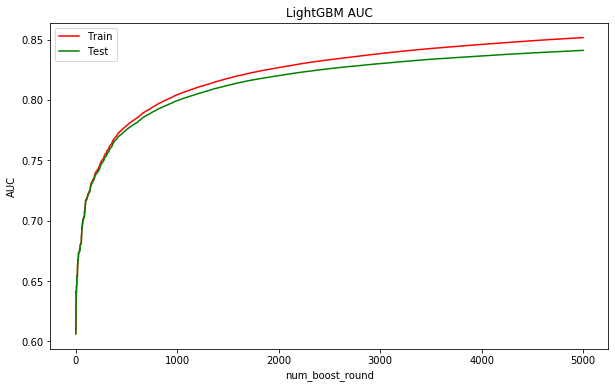

In [43]:
# 绘制在训练过程中的AUC变化
plt.figure(figsize=(10,6))
plt.plot(lgb_progress['train']['auc'],label='Train',color='r')
plt.plot(lgb_progress['test']['auc'],label='Test',color='g')
plt.xlabel('num_boost_round')
plt.ylabel('AUC')
plt.title('LightGBM AUC')
plt.legend()
plt.show()

In [46]:
lgb_ms = metrics_result(y_test, lgb_y_predictions, lgb_y_pred)

精度:0.754
召回:0.754
f1-score:0.754


In [48]:
from sklearn.metrics import accuracy_score
print("准确度：",accuracy_score(y_test,lgb_y_predictions))

准确度： 0.7538125


> ### 传统机器学习方法做短文本分类，效果很一般，二分类准确率75%，5分类准确率大约50%
>
> ### 下面尝试一下使用fasttext来做短文本分类，二分类准确率大约81%，5分类准确率大约56%

In [34]:
import fasttext,re,jieba
from fasttext import train_supervised
from sklearn.utils import shuffle
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [35]:
data = pd.read_csv('H:/3-NLP数据集/1-电影评论/ratings.csv')
data = data.loc[:, ['rating', 'comment']]

In [36]:
df = pd.DataFrame()
data['rating'][(data['rating']<=3)] = 0
data['rating'][(data['rating']> 3)] = 1
data1 = data[(data['rating']==0) & (data['comment'].str.len()>12)][:200000]
data2 = data[(data['rating']==1) & (data['comment'].str.len()>12)][:200000]    

In [37]:
df = pd.concat([data1,data2])

In [39]:
def token(string):
    return re.findall(r'[\d|\w]+',string)

In [40]:
df['comment'] = df['comment'].apply(token)

In [41]:
# 中文分词函数，用正则去除多余的符号,不去掉停用词
def cut_text(text):
    text = str(text)
    text = re.sub('\\\\n|[\n\u3000\r]', ' ', text)
    relu = '！？｡。，＂＃＄％＆＇（）＊＋－／：；＜＝＞＠［＼］＾＿｀\
    ｛｜｝～｟｠｢｣､、〃《》「」『』【】〔〕〖〗〘〙〚〛〜〝〞〟〰〾〿–\
    —‘\'‛“”„‟…‧﹏' + '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~·ʔ•'
    text = re.sub('[{}]'.format(relu), ' ', text)
    seg_list = jieba.cut(text)            
    sentence_segment=[] 
    for word in seg_list:
#         if word not in stopwords:
#             sentence_segment.append(word.strip())
        sentence_segment.append(word)        
    # 把已去掉停用词的sentence_segment，用' '.join()拼接起来
    seg_res = ' '.join(sentence_segment)
    return seg_res

In [42]:
%%time
df['comment'] = df['comment'].apply(cut_text)

Wall time: 1min 22s


In [44]:
def add_label(text):
    new_text = '__label__' + str(text)
    return new_text

In [45]:
df['rating'] = df['rating'].apply(add_label)

In [48]:
df.to_csv('fasttext.txt',index=None)

In [49]:
df = shuffle(df,random_state=0)

In [74]:
df.head()

,rating,comment
124209,__label__1,画面 确实 美 其实 细想 后 椿 是 个 令人感动...
7915,__label__0,漫画 电影 的 一大 特点 在于 以 正义 之名 乱来 哈哈哈 ...
459473,__label__1,四分 电影 五星 鼓励 第一次 在 多伦多 看到 爽...
137923,__label__1,4 很 难得 出场 英雄 这么 多 竟然 没有 一个...
127002,__label__0,真 没有 尴尬 剧情 发展 很 理所当然 是 动画 ...


In [68]:
df[:350000].to_csv('train.txt',index=None,header=None)
df[350000:].to_csv('test.txt',index=None,header=None)

In [69]:
def print_results(N, p, r):
    print("测试数据量：\t" + str(N))
    print("Precision@{}\t{:.3f}".format(1, p))
    print("Recall@{}\t{:.3f}".format(1, r))

In [70]:
# 训练模型
train_data = "train.txt" # 训练集
valid_data = "test.txt" # 验证集

# train_supervised使用与fastText cli相同的参数和默认值
model = train_supervised(
    input=train_data, epoch=10, lr=0.02, wordNgrams=3, verbose=0, minCount=5, dim=100,
    loss="softmax",bucket= 2000000
)
print_results(*model.test(valid_data))

model = train_supervised(
    input=train_data, epoch=10, lr=0.02, wordNgrams=3, verbose=0, minCount=5, dim=100,
    loss="hs",bucket= 2000000
)
print_results(*model.test(valid_data))
model.save_model("cooking.bin")

# 压缩模型
model.quantize(input=train_data, qnorm=True, retrain=True, cutoff=100000)
print_results(*model.test(valid_data))
model.save_model("cooking.ftz")

测试数据量：	50000
Precision@1	0.813
Recall@1	0.813
测试数据量：	50000
Precision@1	0.816
Recall@1	0.816
测试数据量：	50000
Precision@1	0.799
Recall@1	0.799


> ### 下面尝试一下使用albert来做短文本分类，由于没有GPU,只能下载albert_small_zh_google较少的模型来跑一下
>
> ### 由于时间问题，只用了10万条评论数据训练了一轮，ACC只有82%左右，在数据量增大和多跑几轮的话，效果提升会很大

In [78]:
import os,re
import numpy as np
from bert4keras.backend import keras, set_gelu
from bert4keras.tokenizers import Tokenizer
from bert4keras.models import build_transformer_model
from bert4keras.optimizers import Adam, extend_with_piecewise_linear_lr
from bert4keras.snippets import sequence_padding, DataGenerator
from bert4keras.snippets import open
from keras.layers import Lambda, Dense
import pandas as pd
from sklearn.utils import shuffle

Using TensorFlow backend.


In [77]:
os.chdir(r'H:\1-开课吧\03-人工智能与自然语言处理\第二章 人工智能引论与思维方法\第12节 自然语言理解的关键问题\GPT2-Chinese\albert_small_zh_google')

In [79]:
# 切换gelu版本
set_gelu('tanh') 

In [80]:
config_path = 'albert_config_small_google.json'
checkpoint_path = 'albert_model.ckpt'
dict_path = 'vocab.txt'

In [81]:
# 建立分词器
tokenizer = Tokenizer(dict_path, do_lower_case=True)

In [82]:
num_classes = 2
max_len = 128
batch_size = 32

In [83]:
# 加载数据
def load_data(filename):
    D = []
    with open(filename, encoding='utf-8') as f:
        for l in f:
            text, label = l.strip().split('\t')
            D.append((text, int(label)))
    return D

In [139]:
# 把中文多余符号去掉
def token(string):
    string = re.sub('\\\\n|[\n\u3000\r]', ' ', string)
    relu = '！？｡。，＂＃＄％＆＇（）＊＋－／：；＜＝＞＠［＼］＾＿｀\
    ｛｜｝～｟｠｢｣､、〃《》「」『』【】〔〕〖〗〘〙〚〛〜〝〞〟〰〾〿–\
    —‘\'‛“”„‟…‧﹏' + '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~·ʔ•'
    string = re.sub('[{}]'.format(relu), ' ', string)   
    return re.findall(r'[\d|\w]+',string)

In [154]:
# 读取数据
data = pd.read_csv('H:/3-NLP数据集/1-电影评论/ratings.csv')
data = data.loc[:, ['rating', 'comment']]

In [155]:
# 使用apply对comment列去掉多余符号
data['comment'] = data['comment'].apply(token)

In [156]:
# 评分小于等于3的，分类为0，否则为1
data['rating'][(data['rating']<=3)] = 0
data['rating'][(data['rating']> 3)] = 1
# 筛选评分分类为0和1，且comment字符串长度大于8的数据，取5万条数据
data1 = data[(data['rating']==0) & (data['comment'].str.len()>8)][:50000]
data2 = data[(data['rating']==1) & (data['comment'].str.len()>8)][:50000]    
# 合拼数据
df = pd.concat([data1,data2])

In [157]:
# 把数据打乱
df = shuffle(df,random_state = 0)

In [159]:
# 把数据导出为txt文本，index和header为空，分隔符为4个空格，即"\t"
df[['comment','rating']][:90000].to_csv('albert_train.txt',index=None,header=None,sep='\t')
df[['comment','rating']][90000:95000].to_csv('albert_valid.txt',header=None,index=None,sep='\t')
df[['comment','rating']][95000:].to_csv('albert_test.txt',header=None,index=None,sep='\t')

In [160]:
# 加载数据集
train_data = load_data('albert_train.txt')
valid_data = load_data('albert_valid.txt')
test_data = load_data('albert_test.txt')

In [162]:
# 数据生成器

class data_generator(DataGenerator):
    """数据生成器
    """

    def __iter__(self, random=False):
        batch_token_ids, batch_segment_ids, batch_labels = [], [], []
        for is_end, (text, label) in self.sample(random):
            token_ids, segment_ids = tokenizer.encode(text, max_length=max_len)
            batch_token_ids.append(token_ids)
            batch_segment_ids.append(segment_ids)
            batch_labels.append([label])
            if len(batch_token_ids) == self.batch_size or is_end:
                batch_token_ids = sequence_padding(batch_token_ids)
                batch_segment_ids = sequence_padding(batch_segment_ids)
                batch_labels = sequence_padding(batch_labels)
                yield [batch_token_ids, batch_segment_ids], batch_labels
                batch_token_ids, batch_segment_ids, batch_labels = [], [], []

In [163]:
# 加载预训练模型
bert = build_transformer_model(
    config_path=config_path,
    checkpoint_path=checkpoint_path,
    model='albert',
    return_keras_model=False,

)  

In [164]:
# 建立模型，加载权重
output = Lambda(lambda x: x[:, 0], name='CLS-token')(bert.model.output)
output = Dense(
    units=num_classes,
    activation='softmax',
    kernel_initializer=bert.initializer
)(output)

model = keras.models.Model(bert.model.input, output)
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input-Token (InputLayer)        (None, None)         0                                            
__________________________________________________________________________________________________
Input-Segment (InputLayer)      (None, None)         0                                            
__________________________________________________________________________________________________
Embedding-Token (Embedding)     (None, None, 128)    2704384     Input-Token[0][0]                
__________________________________________________________________________________________________
Embedding-Segment (Embedding)   (None, None, 128)    256         Input-Segment[0][0]              
____________________________________________________________________________________________

In [165]:
# 派生为带分段线性学习率的优化器。
# 其中name参数可选，但最好填入，以区分不同的派生优化器。
AdamLR = extend_with_piecewise_linear_lr(Adam, name='AdamLR')

model.compile(
    loss='sparse_categorical_crossentropy',
    # optimizer=Adam(1e-5),  # 用足够小的学习率
    optimizer=AdamLR(learning_rate=1e-4, lr_schedule={
        1000: 1,
        2000: 0.1
    }),
    metrics=['accuracy'],
)

# 转换数据集
train_generator = data_generator(train_data, batch_size)
valid_generator = data_generator(valid_data, batch_size)
test_generator = data_generator(test_data, batch_size)

In [166]:
# 评估函数
def evaluate(data):
    total, right = 0., 0.
    for x_true, y_true in data:
        y_pred = model.predict(x_true).argmax(axis=1)
        y_true = y_true[:, 0]
        total += len(y_true)
        right += (y_true == y_pred).sum()
    return right / total


# 评估类
class Evaluator(keras.callbacks.Callback):
    def __init__(self):
        self.best_val_acc = 0.

    def on_epoch_end(self, epoch, logs=None):
        val_acc = evaluate(valid_generator)
        if val_acc > self.best_val_acc:
            self.best_val_acc = val_acc
            model.save_weights('best_model.weights')
        test_acc = evaluate(test_generator)
        print(
            u'val_acc: %.5f, best_val_acc: %.5f, test_acc: %.5f\n' %
            (val_acc, self.best_val_acc, test_acc)
        )


evaluator = Evaluator()

model.fit_generator(
    train_generator.forfit(),
    steps_per_epoch=len(train_generator),
    epochs=1,
    callbacks=[evaluator]
)

model.load_weights('best_model.weights')
print(u'final test acc: %05f\n' % (evaluate(test_generator)))

Epoch 1/1
2813/2813 [==============================] - 5383s 2s/step - loss: 0.4622 - accuracy: 0.7690
val_acc: 0.81620, best_val_acc: 0.81620, test_acc: 0.81720

final test acc: 0.817200



## 选择4：文章自动续写

在这个作业中你要完成一个文章自动续写的模型。

1.数据获取。（根据你的兴趣采用爬虫技术爬去相关网站上的文本数据内容：比如故事网站，小说网站等）

2.选取模型，并训练。

3.展示一些你模型的输出例子。

In [198]:
import os

os.chdir(r'H:\1-开课吧\03-人工智能与自然语言处理\第二章 人工智能引论与思维方法\第12节 自然语言理解的关键问题\GPT2-Chinese\chinese_L-12_H-768_A-12')

In [173]:
import glob, re
import numpy as np
from tqdm import tqdm
from bert4keras.backend import keras, K
from bert4keras.models import build_transformer_model
from bert4keras.tokenizers import Tokenizer, load_vocab
from bert4keras.optimizers import Adam
from bert4keras.snippets import sequence_padding, open
from bert4keras.snippets import DataGenerator, AutoRegressiveDecoder


In [174]:
maxlen = 256
batch_size = 16
steps_per_epoch = 1000
epochs = 10000

In [175]:
# bert配置
config_path = 'bert_config.json'
checkpoint_path = 'bert_model.ckpt'
dict_path = 'vocab.txt'

In [216]:
novels = []

for txt in glob.glob(r'data\train.txt'):
    txt = open(txt, encoding='utf-8').read()
    txt = txt.replace('\r', '').replace('\n', '')
    txt = txt.replace(u'整理制作，并提供下载', '')
    txt = re.sub(u'www.*?com', '', txt)
    txt = txt.replace(u'\u3000', ' ')
    sents = []
    for t in txt.split('  '):
        #print(t)
        for s in re.findall(u'.*?。', t):
            if len(s) <= maxlen - 2:
                sents.append(s)
    novels.append(sents)

In [190]:
# 加载并精简词表，建立分词器
token_dict, keep_tokens = load_vocab(
    dict_path=dict_path,
    simplified=True,
    startswith=['[PAD]', '[UNK]', '[CLS]', '[SEP]'],
)
tokenizer = Tokenizer(token_dict, do_lower_case=True)

In [191]:
data = []
pbar = tqdm(desc=u'构建语料中', total=sum(len(n) for n in novels))

for novel in novels:
    s = u''
    for i in range(len(novel)):
        for j in range(len(novel) - i):
            if len(s) + len(novel[i + j]) > maxlen - 2:
                data.append(s)
                s = u''
                break
            else:
                s += novel[i + j]
        pbar.update(1)
        if i + j >= len(novel):
            break
    if s:
        data.append(s)

pbar.close()
np.random.shuffle(data)

构建语料中: 100%|████████████████████████████████████████████████████████████| 91726/91726 [00:00<00:00, 176190.25it/s]


In [192]:
class data_generator(DataGenerator):
    """数据生成器
    """
    def __iter__(self, random=False):
        batch_token_ids, batch_segment_ids = [], []
        for is_end, text in self.sample(random):
            token_ids, segment_ids = tokenizer.encode(text)
            batch_token_ids.append(token_ids)
            batch_segment_ids.append(segment_ids)
            if len(batch_token_ids) == self.batch_size or is_end:
                batch_token_ids = sequence_padding(batch_token_ids)
                batch_segment_ids = sequence_padding(batch_segment_ids)
                yield [batch_token_ids, batch_segment_ids], None
                batch_token_ids, batch_segment_ids = [], []

In [201]:
# 构建transformer模型
model = build_transformer_model(
    config_path,
    checkpoint_path,
    application='lm',
    keep_tokens=keep_tokens  # 只保留keep_tokens中的字，精简原字表
)
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input-Token (InputLayer)        (None, None)         0                                            
__________________________________________________________________________________________________
Input-Segment (InputLayer)      (None, None)         0                                            
__________________________________________________________________________________________________
Embedding-Token (Embedding)     (None, None, 768)    10432512    Input-Token[0][0]                
__________________________________________________________________________________________________
Embedding-Segment (Embedding)   (None, None, 768)    1536        Input-Segment[0][0]              
___________________________________________________________________________________________

In [202]:
# 交叉熵作为loss，并mask掉输入部分的预测
y_true = model.input[0][:, 1:]     # 目标tokens
y_mask = model.get_layer('Embedding-Token').output_mask[:, 1:]  # 目标mask
y_mask = K.cast(y_mask, K.floatx())  # 转为浮点型
y_pred = model.output[:, :-1]  # 预测tokens，预测与目标错开一位
cross_entropy = K.sparse_categorical_crossentropy(y_true, y_pred)
cross_entropy = K.sum(cross_entropy * y_mask) / K.sum(y_mask)

model.add_loss(cross_entropy)
model.compile(optimizer=Adam(1e-5))

In [203]:
class StoryCompletion(AutoRegressiveDecoder):
    """基于随机采样的故事续写
    """
    @AutoRegressiveDecoder.set_rtype('probas')
    def predict(self, inputs, output_ids, step):
        token_ids = inputs[0]
        token_ids = np.concatenate([token_ids, output_ids], 1)
        segment_ids = np.zeros_like(token_ids)
        return model.predict([token_ids, segment_ids])[:, -1]

    def generate(self, text, n=1, topk=5):
        token_ids, _ = tokenizer.encode(text)
        results = self.random_sample([token_ids[:-1]], n, topk)  # 基于随机采样
        return [text + tokenizer.decode(ids) for ids in results]


In [204]:
story_completion = StoryCompletion(
    start_id=None, end_id=tokenizer._token_end_id, maxlen=maxlen
)

In [205]:

def generate_text():
    text1 = u'萧炎对这威胁之话还是感到陌生，若非他灵魂力量同样不弱的话，恐怕早就忍不住的出手了。'
    text2 = u'萧炎嘴角掀起一抹微笑，或许，这也会是一种其他的开始。'
    text3 = u'半年时间，眨眼便过。'
    for text in [text1, text2, text3]:
        t = story_completion.generate(text)
        print(u'输入: %s' % text)
        print(u'结果: %s\n' % ('\n'.join(t)))

In [206]:
class Evaluate(keras.callbacks.Callback):
    def __init__(self):
        self.lowest = 1e10

    def on_epoch_end(self, epoch, logs=None):
        # 保存最优
        if logs['loss'] <= self.lowest:
            self.lowest = logs['loss']
            model.save_weights('./best_model.weights')
        # 展示训练效果
        generate_text()


In [ ]:
# 开始训练模型，由于本地没有GPU资源，所以在kaggle上训练了3轮，把模型下载到本地加载
if __name__ == '__main__':

    evaluator = Evaluate()
    train_generator = data_generator(data, batch_size)

    model.fit_generator(
        train_generator.forfit(),
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        callbacks=[evaluator]
    )

else:

    model.load_weights('./best_model.weights')

In [211]:
# 加载训练好的模型权重文件
model.load_weights(r'best_model.weights')

In [221]:
def generate_text():
    text1 = u'萧炎对这威胁之话还是感到陌生，若非他灵魂力量同样不弱的话，恐怕早就忍不住的出手了。'
    text2 = u'萧炎嘴角掀起一抹微笑，或许，这也会是一种其他的开始。'
    text3 = u'半年时间，眨眼便过。'
    for text in [text1, text2, text3]:
        t = story_completion.generate(text)
        print(u'【输入的文章开头】: %s' % text)
        print(u'【文章续写的结果】: %s\n' % ('\n'.join(t)))

In [222]:
%%time
generate_text()

【输入的文章开头】: 萧炎对这威胁之话还是感到陌生，若非他灵魂力量同样不弱的话，恐怕早就忍不住的出手了。
【文章续写的结果】: 萧炎对这威胁之话还是感到陌生，若非他灵魂力量同样不弱的话，恐怕早就忍不住的出手了。在萧炎心神一动，其身形便是化为了一道道影子，对着萧炎狠狠的狠狠砸了过去。这家伙，这是我的对手，我们还真是不知道，你是谁的？一旁的萧厉，也是一愣，眼中掠过一抹惊愕，旋即目光转向萧厉，低声道：萧家，这次，我不是想要将你给解救出来。萧炎笑着道。

【输入的文章开头】: 萧炎嘴角掀起一抹微笑，或许，这也会是一种其他的开始。
【文章续写的结果】: 萧炎嘴角掀起一抹微笑，或许，这也会是一种其他的开始。在萧炎面前，一名斗尊阶别的斗者，正是一脸阴寒，面庞上的狰狞与阴狠，令得他有着一股不可察觉的感觉。你也是斗皇强者。萧炎微微摇了摇头，道。呵呵，这家伙倒是没什么特别的本事啊，他还真有这个性子，不过他也不会在这种事上出什么问题，我还是不敢随意的放过去。萧炎摇了摇头，笑道。

【输入的文章开头】: 半年时间，眨眼便过。
【文章续写的结果】: 半年时间，眨眼便过。在那些年，他们都是拥有着无比庞大的财富以及财气，而这种财富，则正在逐渐地减弱，当他们在心中，却是忽然发现，自己的身体，竟然已经被他们所遗留下来的所有能量所焚烧，因此，当他们的灵魂，都是在此刻，变得极为的虚弱了起来在那一瞬间，萧炎体内的那股灵魂力量，也是开始缓缓的释放而出，然后在那无数道目光的注视下，迅速的消失。

Wall time: 58.6 s
